Author: Ali Parandeh Presenting to: Credit Kudos

# 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import statsmodels as sm
from typing import Tuple
from datetime import datetime

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
# Construct dict of column names that need to be converted to category columns using dict comprehension
dtypes= {col:dtype for col, dtype in zip(['group_id', 'category'], ['category'] * 2)}

In [4]:
df = pd.read_csv('../data/data.csv', dtype=dtypes, infer_datetime_format=True, parse_dates=[2]).sort_values('group_id').set_index('transaction_id')

In [5]:
df.tail()

,group_id,booked_at,amount,category
transaction_id,,,,
74038292,766330,2018-08-19 23:00:00+00:00,2000,Other
74038315,766330,2018-08-19 23:00:00+00:00,4000,Other
74038349,766330,2018-08-19 23:00:00+00:00,4000,Other
74037813,766330,2018-08-23 23:00:00+00:00,5000,Other
74035530,766330,2018-09-23 23:00:00+00:00,15000,Other


# 2. Clean Data

## Investigating transactions Data

In [6]:
# Basic info about each dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 90129894 to 74035530
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   group_id   50000 non-null  category           
 1   booked_at  50000 non-null  datetime64[ns, UTC]
 2   amount     50000 non-null  int64              
 3   category   50000 non-null  category           
dtypes: category(2), datetime64[ns, UTC](1), int64(1)
memory usage: 1.3 MB


Table data types are now all correct

In [7]:
df.isna().sum()

group_id     0
booked_at    0
amount       0
category     0
dtype: int64

No Missing values

In [8]:
df.reset_index().duplicated().sum()

0

No Duplicates

<AxesSubplot:>

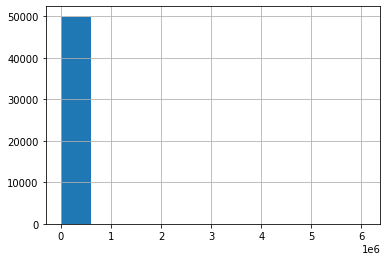

In [9]:
df.amount.hist()

In [10]:
def visualise_outliers(df: pd.DataFrame, figsize: Tuple[int, int]) -> None:
    numerical_cols = df.select_dtypes('int') + df.select_dtypes('float')
    plt.figure(figsize=figsize)
    for i, col in enumerate(numerical_cols):
        plt.subplot(len(df.columns), 1, i+1)
        sns.boxplot(x=df[col])
    plt.tight_layout()

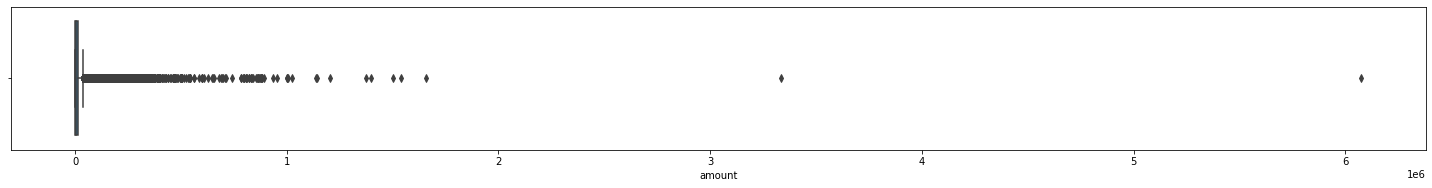

In [11]:
visualise_outliers(df, (20, 10))

In [12]:
df[df.amount > 2000000]

,group_id,booked_at,amount,category
transaction_id,,,,
43783432,723945,2018-08-19 23:00:00+00:00,3333000,Other
43910294,726029,2019-04-11 14:04:21+00:00,6075000,Other


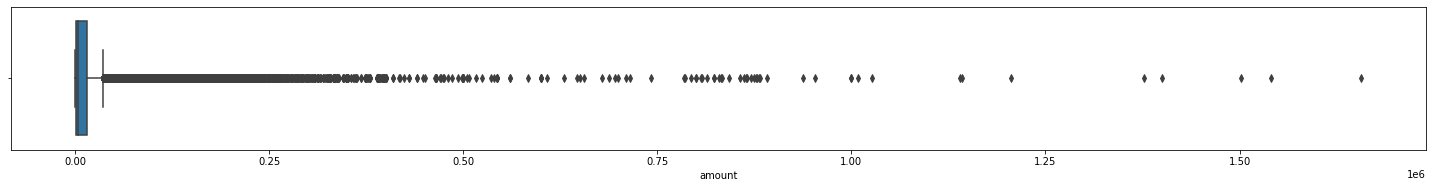

In [13]:
#  Remove outlier points
visualise_outliers(df[df.amount < 2000000], (20, 10))

In [14]:
def drop_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # Let's drop all the outliers (say anything above 3x standard deviations above mean)
    for col in df.columns:
        if df[col].dtype == 'int' or df[col].dtype == 'float':
            mean, std = df[col].mean(), df[col].std()
            cut_off  = mean + 3 * std
            df = df[df[col] <= cut_off]
    return df

In [15]:
df = drop_outliers(df)

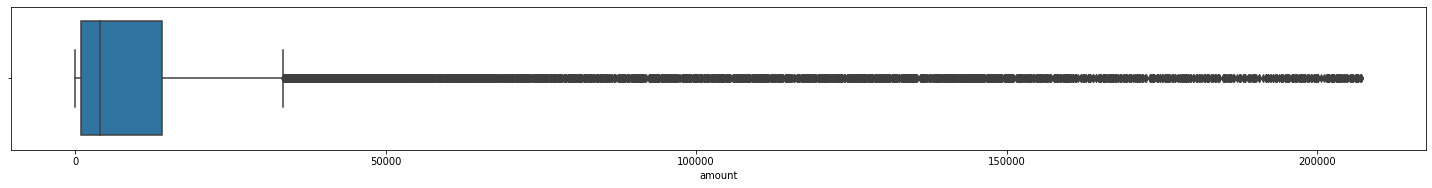

In [16]:
visualise_outliers(df, (20, 10))

### Feature Engineering using datetime columns

Since datettime data don't work well with classification models, we need to feature engineer them to become categorical columns. One way to do this is to extract year, month and day of month or week from scheme start date. Schem start date can can be a working day or weekday or bank holiday. 

In [17]:
from dateutil.relativedelta import relativedelta

def yearsago(years, from_date=None):
    if from_date is None:
        from_date = datetime.now()
    return (from_date - relativedelta(years=years)).year

In [18]:
df['yearsago'] = df.booked_at.apply(lambda x: yearsago(x.year))

In [19]:
df['start_date_year'] = df.booked_at.dt.year
df['start_date_month'] = df.booked_at.dt.month
df['start_date_week'] = df.booked_at.dt.week
df['start_date_day'] = df.booked_at.dt.day
df['start_date_day_of_week'] = df.booked_at.dt.dayofweek

<ipython-input-19-d105ef94c84c>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['start_date_week'] = df.booked_at.dt.week


# 3. Explatory Data Analysis

In [20]:
# Slice columns into numerical, datetime,  categorical
numerical_cols = list(df.select_dtypes('int').columns) + list(df.select_dtypes('float').columns)
categorical_cols = df.select_dtypes('category').columns
datetime_cols = df.select_dtypes('datetime').columns

In [21]:
#  Visualise numerical features vs income
def visualise_numerical_correlations(df, no_cols, figsize):
    numerical_cols = list(df.select_dtypes('int').columns) + list(df.select_dtypes('float').columns)
    plt.figure(figsize=figsize)
    for i, col in enumerate(numerical_cols):
        try:
            plt.subplot(int(np.ceil(len(numerical_cols) / 3)), 3, i+1)
            plt.title(col)
            # Use violin plots to understand data distribution better.
            sns.violinplot(x="category", y=col, data=df, points='inner')
        except Exception as e:
            logging.error(e)
        
    plt.tight_layout()

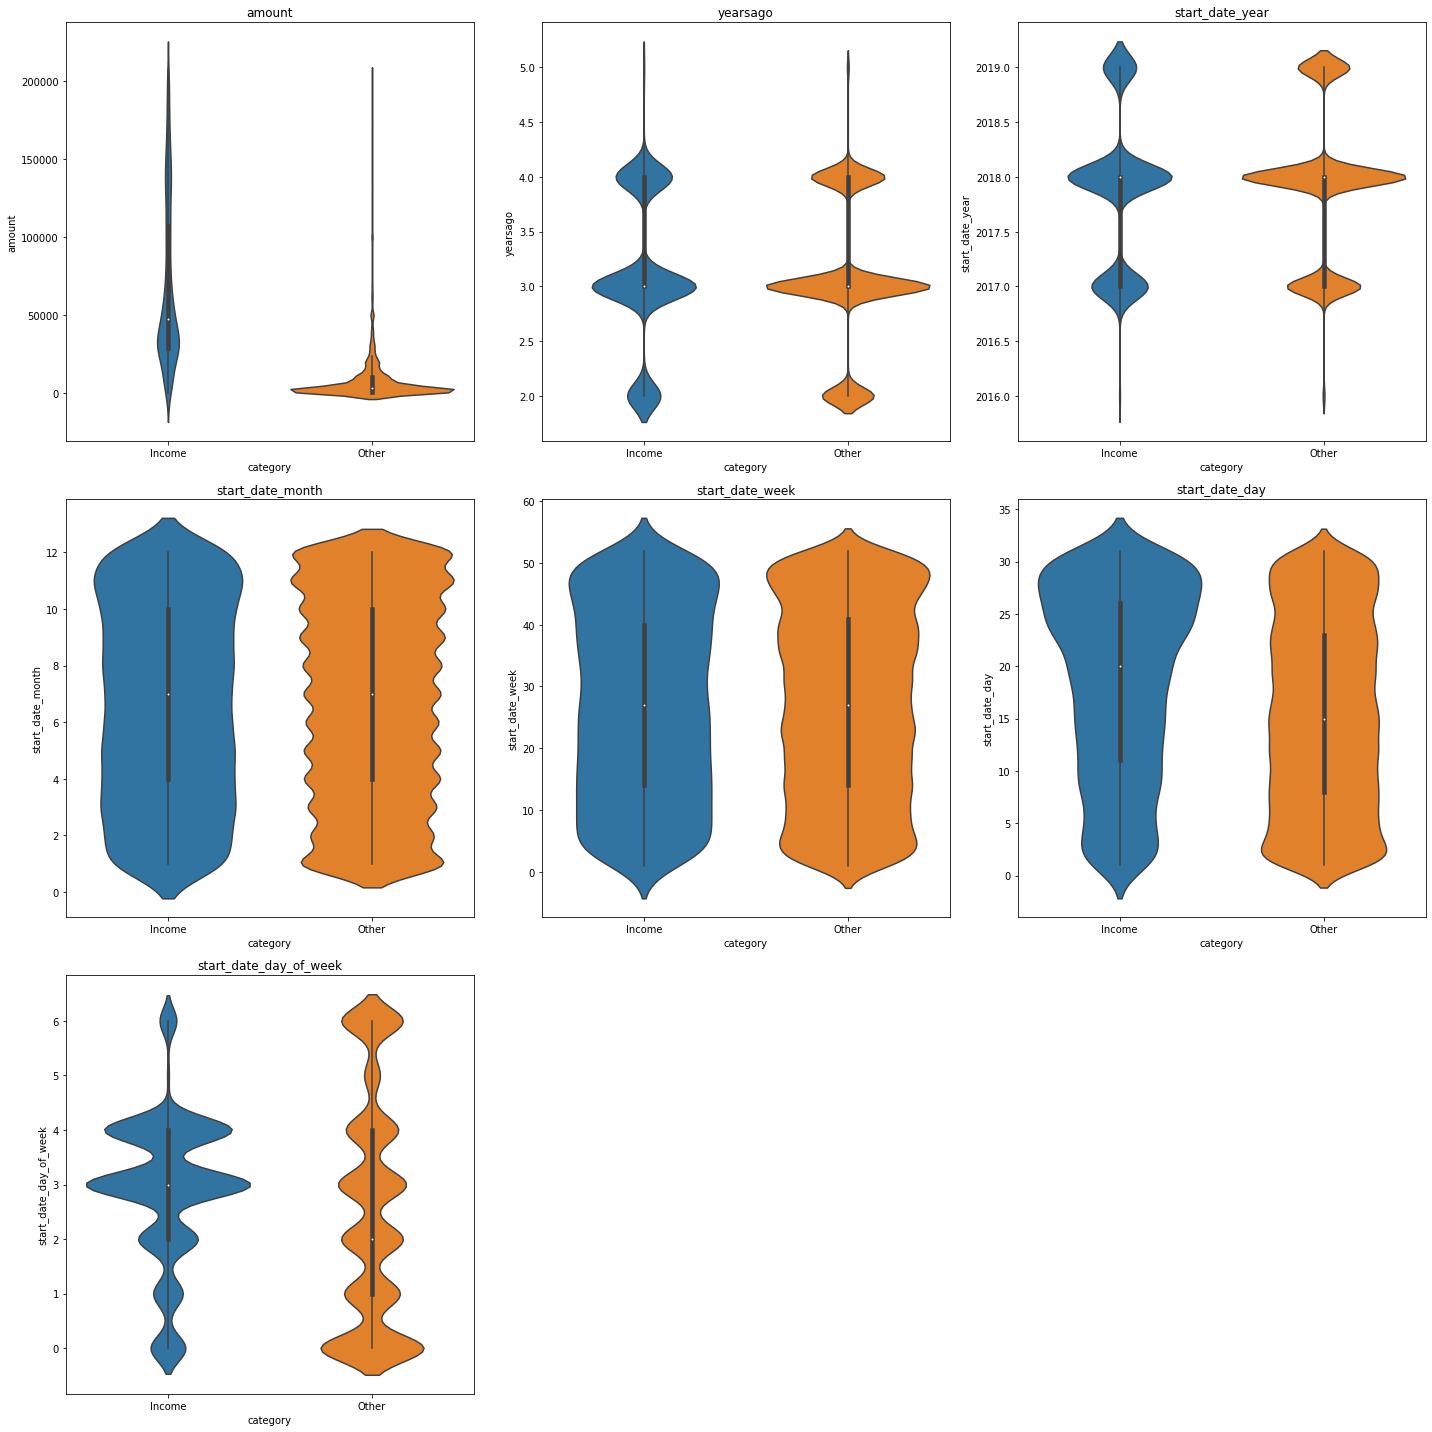

In [22]:
visualise_numerical_correlations(df, 4, (20, 20))

<AxesSubplot:>

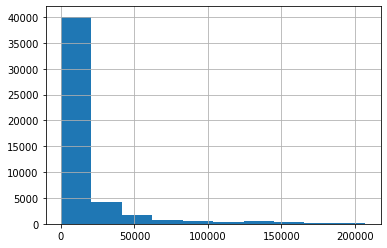

In [23]:
df.amount.hist()

<AxesSubplot:>

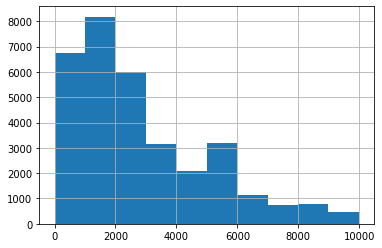

In [24]:
df[df.amount < 10000].amount.hist()

<AxesSubplot:>

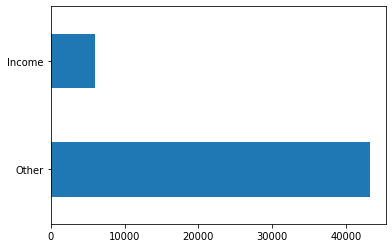

In [25]:
df.category.value_counts().plot.barh()

<AxesSubplot:>

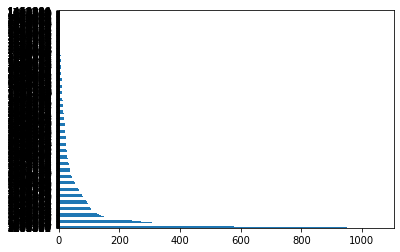

In [26]:
df.group_id.value_counts().plot.barh()

In [27]:
counts = df.group_id.value_counts()

<AxesSubplot:>

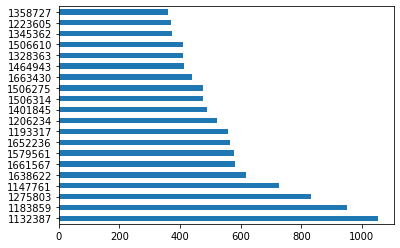

In [28]:
counts.nlargest(20).plot.barh()

<AxesSubplot:>

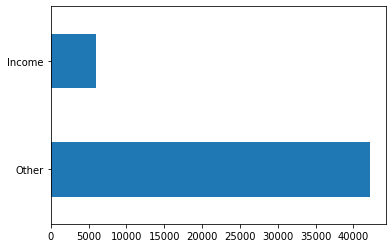

In [29]:
df[df.group_id.isin(counts[counts < 1000].index)].category.value_counts().plot.barh()

In [30]:
# Specify the boundaries of the bins
bins = [-np.inf, 10000, 50000, 100000, 149999, np.inf]

# Bin labels
labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

# Bin the continuous variable ConvertedSalary using these boundaries
df['amount_binned'] = pd.cut(df['amount'], bins=bins, labels=labels)

# Print the first 5 rows of the amount_binned column
print(df[['amount_binned', 'amount']].head())

               amount_binned  amount
transaction_id                      
90129894            Very low    5589
90130241            Very low    5700
90130344            Very low    1350
90142871                 Low   50000
90142519              Medium   90000


In [31]:
def visualise_categorical_correlations(df: pd.DataFrame, figsize: Tuple[int, int]) -> None:
    # Construct list of categorical and boolean colunmns alongside the outcome label column 
    categorical_cols = ['category', 'amount_binned']
    
    #  One-hot encode the categorical columns to enable pairwise correlations for the first 500 rows of data      
    dummies = pd.get_dummies(df[categorical_cols])
    corr = dummies.corr()

    # Top half of the heatmap is redundant - Can use a mask to hide it         
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(dummies.corr(),linewidths=.1,cmap="YlGnBu", annot=True, mask=mask, vmax=.3, square=True)
    plt.yticks(rotation=0);

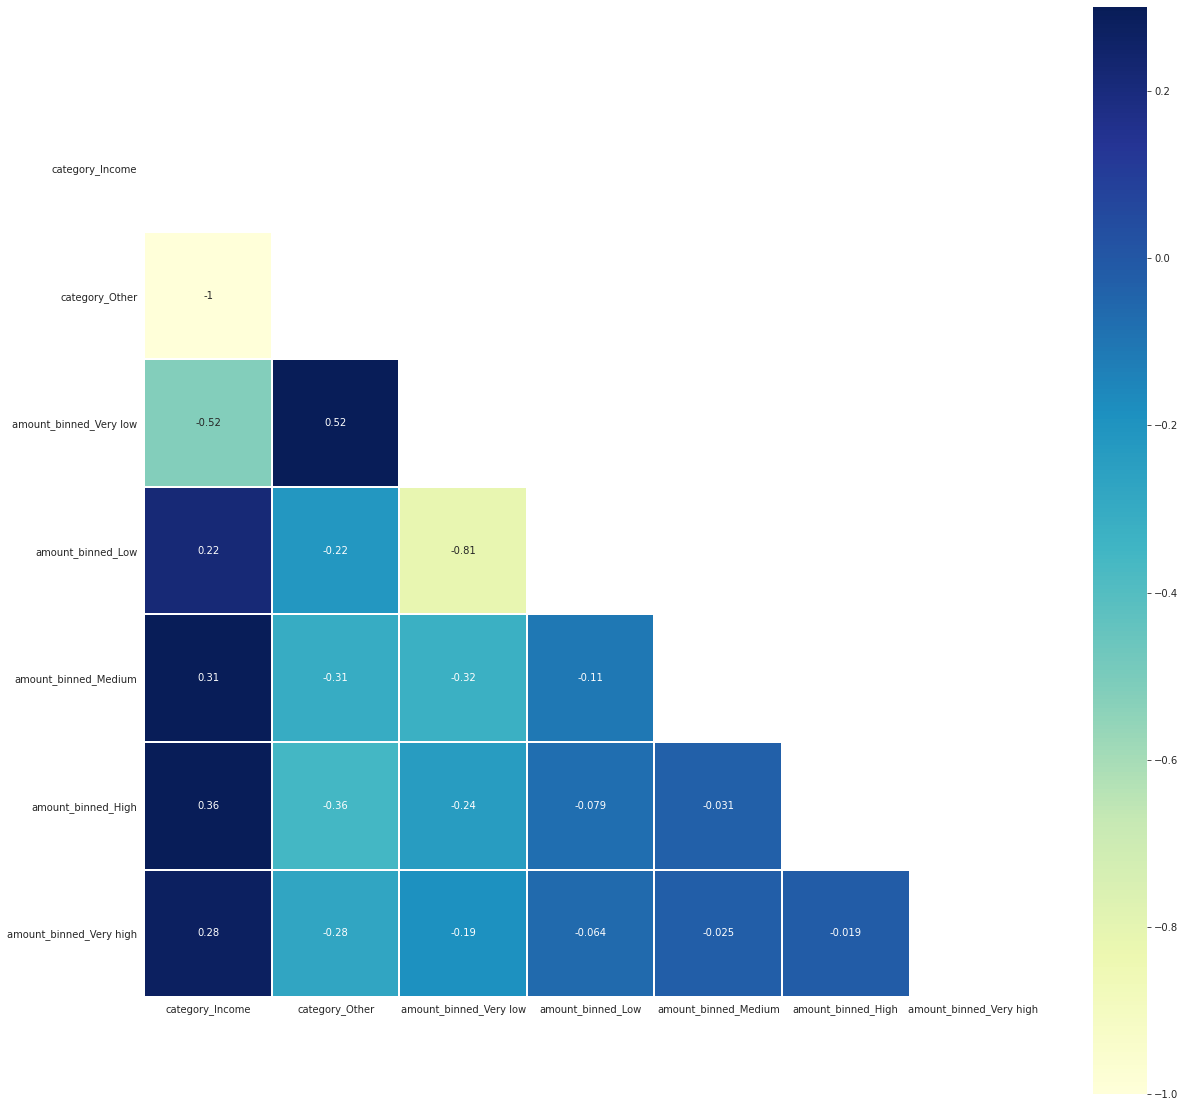

In [32]:
visualise_categorical_correlations(df, (20, 20))

# 4. Build ML Model

## 4.1 Splitting Data

In [33]:
label = 'category'

In [100]:
df.head()

,group_id,booked_at,amount,category,yearsago,start_date_year,start_date_month,start_date_week,start_date_day,start_date_day_of_week,amount_binned
transaction_id,,,,,,,,,,,
90129894,1124444,2019-05-18 00:00:00+00:00,5589,Other,2,2019,5,20,18,5,Very low
90130241,1124444,2019-01-18 00:00:00+00:00,5700,Other,2,2019,1,3,18,4,Very low
90130344,1124444,2018-12-21 00:00:00+00:00,1350,Other,3,2018,12,51,21,4,Very low
90142871,1124725,2018-02-13 00:00:00+00:00,50000,Other,3,2018,2,7,13,1,Low
90142519,1124725,2018-07-04 23:00:00+00:00,90000,Other,3,2018,7,27,4,2,Medium


In [68]:
from sklearn.model_selection import train_test_split

# Drop all rows with na data
model_df = df.reset_index().copy()

label = 'category'

features_df = pd.get_dummies(model_df.drop(columns=[label,'booked_at', 'transaction_id']), drop_first=True)
labels_df = model_df[label].replace({'Other': False, 'Income': True})

# One hot encode all categorical columns.
# Drop all columns that have no correlations with the label
X, y = features_df.values, labels_df.values

# Split data 70%-30% into training set and test set,
# As labels column (active and cancelled subscription) classes are unbalanced - we will use a stratified split to represent this unbalance in the test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y, shuffle=True)

In [69]:
print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 34434
Test cases: 14758


In [76]:
X_train_df = pd.DataFrame(X_train, columns=features_df.columns)
X_test_df = pd.DataFrame(X_test, columns=features_df.columns)

## 4.2 Log Transforming

In [77]:
from sklearn.preprocessing import PowerTransformer

scalar = PowerTransformer()

scalar.fit(X_train_df[['amount']])

X_train_df['amount_log_scaled'] = scalar.transform(X_train_df[['amount']])
X_test_df['amount_log_scaled'] = scalar.transform(X_test_df[['amount']])

<AxesSubplot:>

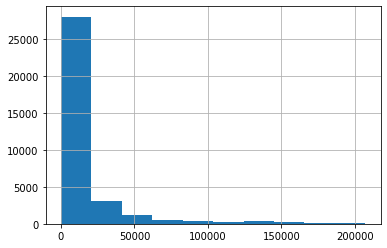

In [78]:
X_train_df['amount'].hist()

<AxesSubplot:>

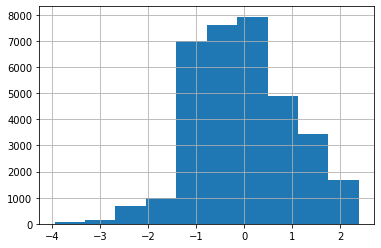

In [74]:
X_train_df['amount_log_scaled'].hist()

In [83]:
X_train = X_train_df.drop(columns='amount').values
X_test = X_test_df.drop(columns='amount').values

## 4.3 Dealing with unbalanced classes

<AxesSubplot:>

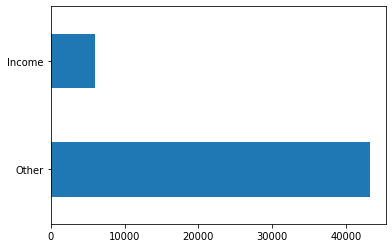

In [34]:
# Let's see how balanced the label classes are in the dataset
df[label].value_counts().plot.barh()

In [99]:
df[label].value_counts()

Other     43185
Income     6007
Name: category, dtype: int64

Re-sampling techniques are divided in two categories:

- Under-sampling the majority class(es).
- Over-sampling the minority class.
- Combining over- and under-sampling.
- Create ensemble balanced sets.

A third-party package to help with this is [imbalanced-learn](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn)

I will skip doing this for now as we have nearly enough sample of miniority class to build an accurate model (>6000). It would be better if this was 10K at least but if the model is not performing well, I can come back and add perform the following action:


In [107]:
from imblearn.over_sampling import BorderlineSMOTE

# Define the resampling method
method = BorderlineSMOTE(kind='borderline-1')

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

<AxesSubplot:>

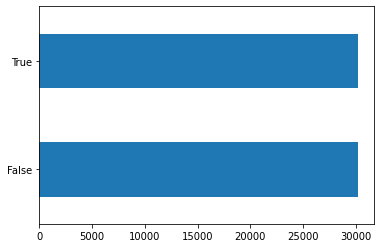

In [116]:
pd.Series(y_resampled).value_counts().plot.barh()

In [130]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_resampled, y_resampled)

print (model)

LogisticRegression(C=100.0, solver='liblinear')


In [118]:
predictions = model.predict(X_test)
print('Predicted labels: ', predictions)
print('Actual labels:    ' ,y_test)

Predicted labels:  [False False False ... False False False]
Actual labels:     [False False False ... False False False]


In [119]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.9992546415503456


In [120]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     12956
        True       1.00      1.00      1.00      1802

    accuracy                           1.00     14758
   macro avg       1.00      1.00      1.00     14758
weighted avg       1.00      1.00      1.00     14758



The classification report includes the following metrics for each class (False and True) on the outcome column (label)

- **Precision:** Of the predictions the model made for this class, what proportion were correct?
- **Recall:** Out of all of the instances of this class in the test dataset, how many did the model identify?
- **F1-Score:** An average metric that takes both precision and recall into account.



In [121]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

[[12953     3]
 [    8  1794]]


In [122]:
from collections import Counter

In [123]:
Counter(predictions)

Counter({False: 12961, True: 1797})

In [124]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))

Overall Precision: 0.998330550918197
Overall Recall: 0.9955604883462819


In [125]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[9.99776351e-01 2.23649255e-04]
 [9.99741903e-01 2.58097488e-04]
 [9.98975410e-01 1.02458971e-03]
 ...
 [9.99036334e-01 9.63666116e-04]
 [9.98391367e-01 1.60863324e-03]
 [9.99995961e-01 4.03905960e-06]]


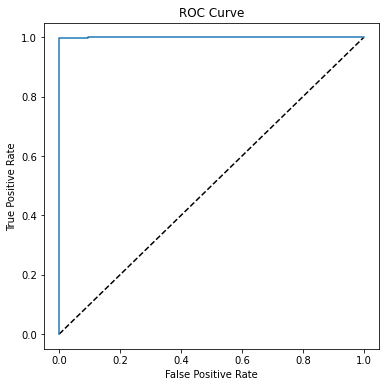

In [126]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [127]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

[[12953     3]
 [    8  1794]]


The ROC chart shows the curve of the true and false positive rates for different threshold values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the chart represents the probability of predicting correctly with a 50/50 random prediction; so we obviously want the curve to be higher than that (or our model is no better than simply guessing!).

The area under the curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model. scikit-Learn includes a function to calculate this metric.


In [128]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

AUC: 0.999941319360088


There are several ways one can improve this AUC and precision and recall scores:

1. Scaling numeric features so they're on the same scale. This prevents features with large values from producing coefficients that disproportionately affect the predictions.
2. Trying a different algorithm. Previously we used a logistic regression algorithm, which is a linear algorithm. There are many kinds of classification algorithm we could try, including:
   - **Support Vector Machine algorithms:** Algorithms that define a hyperplane that separates classes.
   - **Tree-based algorithms:** Algorithms that build a decision tree to reach a prediction
   - **Ensemble algorithms:** Algorithms that combine the outputs of multiple base algorithms to improve generalizability.
3. Hyperparameter Tuning on algorithms to build a model that fit the data better while avoiding underfitting and overfitting.
4. Instead of dropping missing data, impute missing values with statistically sound values such that we have more data to train with.
5. Feature engineering new features that correlate with the labels we want to predict on better.
6. Principal Component Analysis (PCA) to reduce features / dimensions in the data that do not help in constructing an accurate model.



# Tring a different algorithm

In [129]:
# Train the model
from sklearn.ensemble import AdaBoostClassifier
# train a AdaBoostClassifier model on the training set
model = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

print (model)

AdaBoostClassifier(n_estimators=100)


Confusion Matrix:
 [[12832   124]
 [  223  1579]] 

Accuracy: 0.9764873289063559
Overall Precision: 0.9271873165002936
Overall Recall: 0.8762486126526082

AUC: 0.9926753925777642


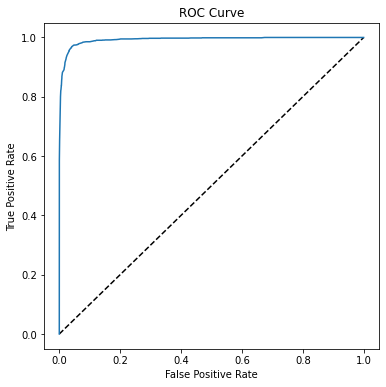

In [97]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Saving and Loading model for inference


In [131]:
import joblib

# Save the model as a pickle file
filename = '../models/income_model.pkl'
joblib.dump(model, filename)

['../models/income_model.pkl']

In [132]:
X_new = np.array([X_test[200], X_test[124]])

In [133]:
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model.predict(X_new)

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one patient, so our prediction is the first one in the resulting array.
print('Predicted outcome is {}'.format(pred[0]))

New sample: [3.0, 2018.0, 9.0, 38.0, 23.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [135]:
pred = model.predict(X_new)
print('Predicted outcome is {}'.format(pred[1]))

Predicted outcome is True


# 5. Conclusion

As shown above, given an array of values based on the defined columns, one can get a prediction from the model. The model has been trained on the patterns seen in the data. In particular, the relationships between each feature column and the label column. The model is in fact a function that has mapped a hyperplane in a high dimensional search space. 

[scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) has a great visual on how each algorithm can build a different model that create a different separation. In this notebook, we used logistic regression and AdaBoostClassifier algorithms.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png' />